In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import zipfile
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# No. of classes
num_classes = 325

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  #  multi-class classification
])

In [ ]:
with zipfile.ZipFile('archive_tamizhi.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_data')
train_path = '/content/extracted_data/archive/train'
test_path = '/content/extracted_data/archive/test'


print(f"Train Path: {train_path}")
print(f"Test Path: {test_path}")

Train Path: /content/extracted_data/archive/train
Test Path: /content/extracted_data/archive/test


In [ ]:
with zipfile.ZipFile('Images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/img')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)


#model training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=20, validation_data=test_generator)

Found 15353 images belonging to 325 classes.
Found 3142 images belonging to 325 classes.
Epoch 1/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 112s 229ms/step - accuracy: 0.0275 - loss: 5.4437 - val_accuracy: 0.4020 - val_loss: 2.3283
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 108s 224ms/step - accuracy: 0.2754 - loss: 2.7920 - val_accuracy: 0.6540 - val_loss: 1.1996
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 107s 223ms/step - accuracy: 0.4631 - loss: 1.7527 - val_accuracy: 0.7896 - val_loss: 0.7817
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 139s 217ms/step - accuracy: 0.5951 - loss: 1.2452 - val_accuracy: 0.8574 - val_loss: 0.6107
Epoch 5/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 114s 237ms/step - accuracy: 0.6818 - loss: 0.9527 - val_accuracy: 0.8908 - val_loss: 0.5177
Epoch 6/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 134s 220ms/step - accuracy: 0.7341 - loss: 0.7924 - val_accuracy: 0.9074 - val_loss: 0.5464
Epoch 7/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 107s 223ms/step - accuracy: 0.7657 - loss: 0.6756 - val_accuracy: 0.9233 - val_

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}')


99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9546 - loss: 0.4102
Test accuracy: 0.96


In [ ]:
model.save('tamizhi_ocr_model.h5')

In [ ]:
model = tf.keras.models.load_model('/content/tamizhi_ocr_model.h5')

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image.astype(np.uint8)
    return image

<ipython-input-22-103e02680e67>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


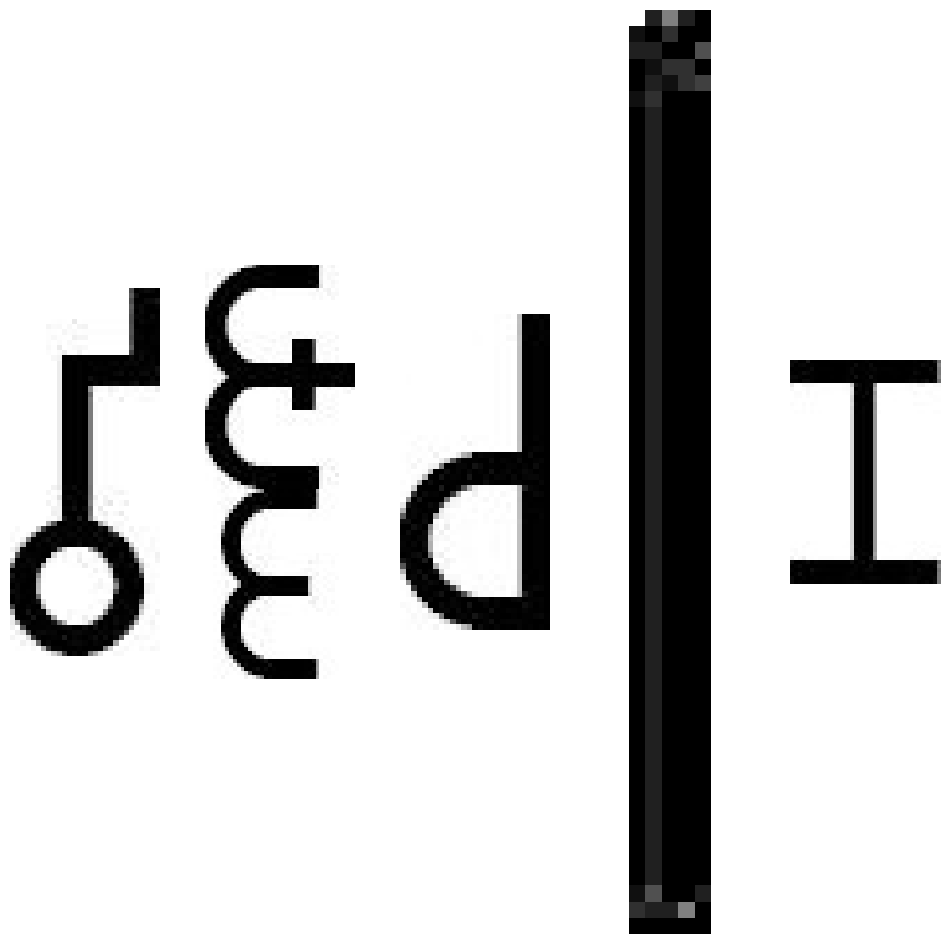

In [ ]:
def segment_characters_without_dots(image):

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    character_images = []

    for label in range(1, num_labels):
        # bounding box
        x, y, w, h, area = stats[label]
        if area < 50 or w < 3 or h < 10:
            continue
        char_image = image[y:y+h, x:x+w]
        character_images.append((x, char_image))

    character_images = sorted(character_images, key=lambda elem: elem[0])
    character_images = [img[1] for img in character_images]

    return character_images

def plot_characters_dynamically(character_images):
    num_chars = len(character_images)
    if num_chars == 0:
        print("No characters detected.")
        return

    cols = 5
    rows = (num_chars + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(12, 12), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
    axs = axs.flatten()

    for i, char_image in enumerate(character_images):
        axs[i].imshow(char_image, cmap='gray')
        axs[i].axis('off')

    for j in range(i + 1, rows * cols):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


image_path = '/content/img/Images/vijasarana.png'
image = cv2.imread(image_path)
character_images = segment_characters_without_dots(image)

plot_characters_dynamically(character_images)

In [ ]:
import cv2
import numpy as np

def predict_character_sequence(image_path, model, class_labels):
    image = cv2.imread(image_path)
    character_images = segment_characters_without_dots(image)
    predicted_sequence = []
    for char_img in character_images:
        char_img = cv2.resize(char_img, (64, 64))
        char_img = char_img.astype('float32') / 255.0
        char_img = np.expand_dims(char_img, axis=-1)
        char_img = np.expand_dims(char_img, axis=0)
        predictions = model.predict(char_img)
        predicted_class = np.argmax(predictions)
        predicted_character = class_labels[predicted_class]
        predicted_sequence.append(predicted_character)

    sequence = ' '.join(predicted_sequence)
    print(f"Predicted Sequence: {sequence}")
    return sequence

In [ ]:
test_folder_path = '/content/extracted_data/archive/test'
class_labels = sorted(os.listdir(test_folder_path))

In [ ]:
sequence_image_path = '/content/img/Images/vijasarana.png'
predicted_sequence = predict_character_sequence(sequence_image_path, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Sequence: 184 248 39 156 78


In [ ]:
file_path = '/content/Unicode_map - unicode_map (2).csv'
try:
    data = pd.read_csv(file_path, header=None)
except FileNotFoundError:
    print(f"File not found at {file_path}")
    raise
except pd.errors.EmptyDataError:
    print("The CSV file is empty.")
    raise

data.columns = ['Class Name', 'Unicode']
data['Unicode'] = data['Unicode'].astype(str).str.strip()

unicode_map = {}
for _, row in data.iterrows():

    class_name = str(row['Class Name'])
    #print(class_name)
    unicode_value = row['Unicode']
    try:
        combined_character = "".join(
            chr(int(code_point[2:], 16)) for code_point in unicode_value.split() if code_point.startswith('U+')
        )
        unicode_map[class_name] = combined_character
    except ValueError:
        print(f"Invalid Unicode format for class {class_name}: '{unicode_value}'")

def get_unicode_sequence(class_names):
    class_name_list = class_names.split()
    characters = [unicode_map.get(name, "?") for name in class_name_list]
    return " ".join(characters)

class_name_input = predict_character_sequence(sequence_image_path, model, class_labels)
unicode_sequence = get_unicode_sequence(class_name_input)
print(f"Unicode Sequence: {unicode_sequence}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted Sequence: 184 248 39 156 78
Unicode Sequence: வி ஜா ச ர ண
